# Tutorial 9: CITE-seq (GSE163120 KO4)

DePass was applied to the mouse glioblastomas dataset (13,915 cells) for cross-modal integration. This tutorial demonstrates clustering and dimensionality reduction (UMAP) visualization. 

### Preparation

In [1]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('/home/jyx/DePass/')

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'

path = '../data/dataset_GSE163120_KO4'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

### Loading and Preprocessing

In [ ]:
# read data
adata_omics1 = sc.read_h5ad('../data/dataset_GSE163120_KO4/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_GSE163120_KO4/adata_ADT.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='protein')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}

### Training the model

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='single_cell',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: single_cell | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:19<00:00, 10.28it/s]


Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding

### Clustering

In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=22,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [ ]:
from DePass.utils import super_eval
import pandas as pd
re = super_eval(adata.obs['DePass'],adata.obs['Y'])
pd.DataFrame(list(re.items()), columns=['metric', 'Value']).to_csv(path + '/re.csv', sep='\t', index=True, float_format='%.6f')
print(re)

{'AMI': 0.7454006080646113, 'NMI': 0.7468384564084884, 'ARI': 0.5050983505614217, 'Homogeneity': 0.7800637712886742, 'V-measure': 0.7468384564084883, 'Mutual Information': 2.1384562465471446}


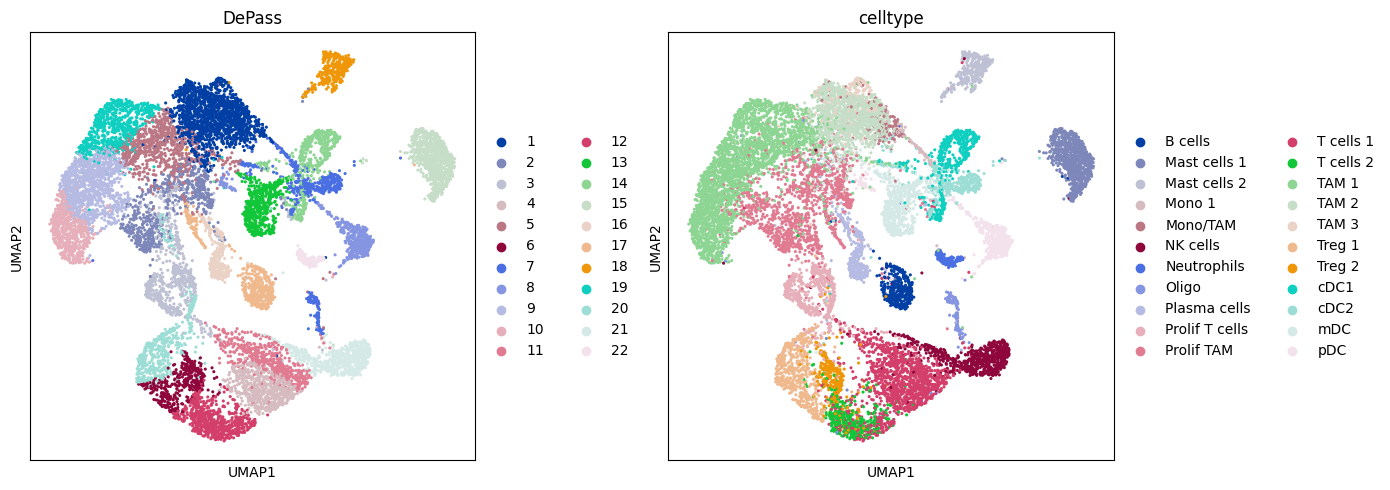

In [6]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pp.neighbors(adata, use_rep='DePass', n_neighbors=30)
sc.tl.umap(adata)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  
sc.pl.umap(
    adata, 
    color='DePass', 
    title='DePass', 
    ax=axs[0],   
    s=20, 
    show=False
)
sc.pl.umap(
    adata, 
    color='cluster', 
    title='celltype', 
    ax=axs[1],   
    s=20, 
    show=False
)
plt.tight_layout()
plt.savefig(path + '/DePass.png', bbox_inches='tight', dpi=300)
plt.show()